# Assignment #4: Linear Models and Decision Trees
## Foundations of Machine Learning
## Do Q1 and one other question.
### Advice: Reuse your code and code from lectures, package routine tasks into functions, make plans about how you'll carry out the analysis before jumping into writing code, and work as efficiently as possible

**Q1.** This question is a case study for linear models and decision trees. The data are about car prices. In particular, they include:

  - `Price`, `Color`, `Seating_Capacity`
  - `Body_Type`: crossover, hatchback, muv, sedan, suv
  - `Make`, `Make_Year`: The brand of car and year produced
  - `Mileage_Run`: The number of miles on the odometer
  - `Fuel_Type`: Diesel or gasoline/petrol
  - `Transmission`, `Transmission_Type`:  speeds and automatic/manual

  1. Load `cars_hw.csv`. These data were really dirty, and I've already cleaned them a significant amount in terms of missing values and other issues, but some issues remain (e.g. outliers, badly scaled variables that require a log or arcsinh transformation). Clean the data however you think is most appropriate.
  2. Summarize the `Price` variable and create a kernel density plot. Use `.groupby()` and `.describe()` to summarize prices by brand (`Make`). Make a grouped kernel density plot by `Make`. Which car brands are the most expensive? What do prices look like in general?
  3. Split the data into an 80% training set and a 20% testing set.
  4. Let's focus on linear models. Make a model where you regress price on the numeric variables alone; what is the $R^2$ and `RMSE` on the test set? Make a second model where, for the categorical variables, make a model comprised of one-hot encoded regressors/features alone, and regress price on those variables; what is the $R^2$ and `RMSE` on the test set? Which model performs better on the test set? Make a third model that combines all the regressors from the previous two; what is the $R^2$ and `RMSE` on the test set? Does the joint model perform better or worse, and by home much?
  5. Use the `PolynomialFeatures` function from `sklearn` to expand the set of numerical variables you're using, along with the categorical variables. As you increase the degree of the expansion, how do the $R^2$ and `RMSE` change? At what point does $R^2$ go negative on the test set? For your best model with expanded features, what is the $R^2$ and `RMSE`? How does it compare to your best model from part 3?
  6. For your best model so far, determine the predicted values for the test data and plot them against the true values. Do the predicted values and true values roughly line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero? Evaluate the strengths and weaknesses of your model.
  7. Now, let's use a regression tree. Construct an appropriate matrix of regressors/features, and fit a tree to the data. Vary the maximum depth of the decision tree using the `max_depth` option (i.e. `tree.DecisionTreeRegressor(max_depth=D)`), and compute the $R^2$ and `RMSE` on the test set of a variety of depths. What depth tree gives the best results?
  8. For your best tree, determine the predicted values for the test data, and plot them against the true values. Do the predicted values and true values line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero?
  12. Which model --- linear model or classification and regression tree --- has better performance on the test set?

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

url = 'https://raw.githubusercontent.com/das3jk/assignment4/main/data/cars_hw.csv'
df = pd.read_csv(url)

df['Mileage_Run'].hist(bins=20) # no outliers
df['age'] = (2023-df['Make_Year'])
df['age'].hist(bins=10) # Convert year to age -- no outliers
#sns.scatterplot(data=df,y='Mileage_Run',x=df['age']) # Some outliers present -- some in lower levels of 12, 9, 8, 7, and upper level of 1-4


<Axes: >

<Axes: xlabel='age_arc', ylabel='Mileage_Run_arc'>

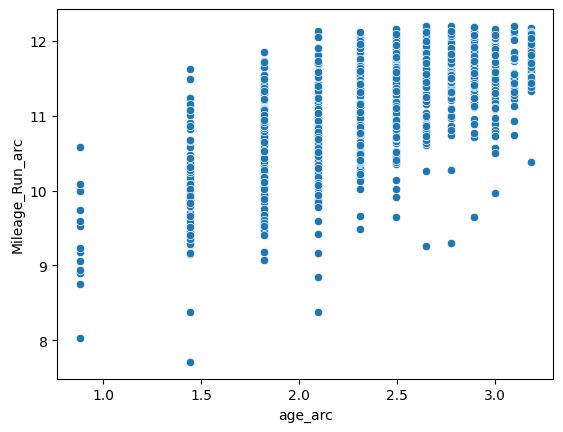

In [28]:
# Take arcsinh transformation to rescale the variables
df['Mileage_Run_arc'] = np.arcsinh(df['Mileage_Run'])
df['age_arc'] = np.arcsinh(df['age'])
sns.scatterplot(data=df,y='Mileage_Run_arc',x='age_arc') # Several outliers here too -- some in the higer age componet


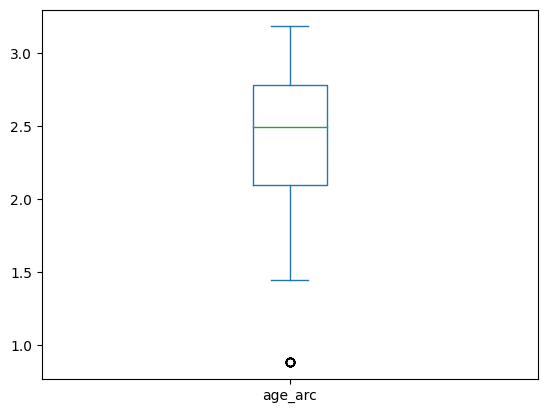

In [29]:
#df['Mileage_Run_arc'].plot.box() # Outliers below 9.25
df['age_arc'].plot.box() # 1 outlier below 1

# Drop outliers:
df = df.loc[df['Mileage_Run_arc']>8.5,:]
df = df.loc[df['age_arc']>0,:]


In [30]:
sns.scatterplot(data=df,y='Mileage_Run_arc',x='age_arc')

<Axes: xlabel='age_arc', ylabel='Mileage_Run_arc'>

In [31]:
#Taken from lecture notes
from sklearn.linear_model import LinearRegression
def slr(x,y): # Single Linear Regression Function
    x_bar = np.mean(x)
    y_bar = np.mean(y)
    b1 = np.inner(x-x_bar,y-y_bar)/np.inner(x-x_bar,x)
    b0 = y_bar - b1*x_bar
    y_hat = b0 + b1*x
    residuals = y - y_hat
    return({'b0':b0,'b1':b1,'y_hat':y_hat,'residuals':residuals})

x = df['age_arc']
y = df['Mileage_Run_arc']

coef = slr(x,y)

y_hat = coef['b0']+coef['b1']*x
plt.scatter(x,y,label='Data')
plt.plot(x,y_hat,label='Regression Line',color='black')
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(loc='upper right')
plt.title('Linear Regression: Looks OK')

plt.show()

count    9.720000e+02
mean     7.414331e+05
std      3.678152e+05
min      1.880000e+05
25%      4.757500e+05
50%      6.665000e+05
75%      8.830000e+05
max      2.941000e+06
Name: Price, dtype: float64
               Price                                                    \
               count          mean           std        min        25%   
Make                                                                     
Chevrolet        6.0  4.535000e+05  2.466064e+05   267000.0   288500.0   
Datsun           3.0  2.896667e+05  1.050397e+04   279000.0   284500.0   
Ford            52.0  7.211731e+05  1.409277e+05   290000.0   635000.0   
Honda           73.0  7.989726e+05  2.665091e+05   316000.0   581000.0   
Hyundai        304.0  6.918322e+05  2.796180e+05   248000.0   484750.0   
Jeep             4.0  1.499500e+06  1.525134e+05  1290000.0  1447500.0   
Kia              8.0  1.614750e+06  1.190567e+05  1369000.0  1579000.0   
MG Motors       35.0  1.869457e+06  1.216611e+05  158900

<Figure size 640x480 with 0 Axes>

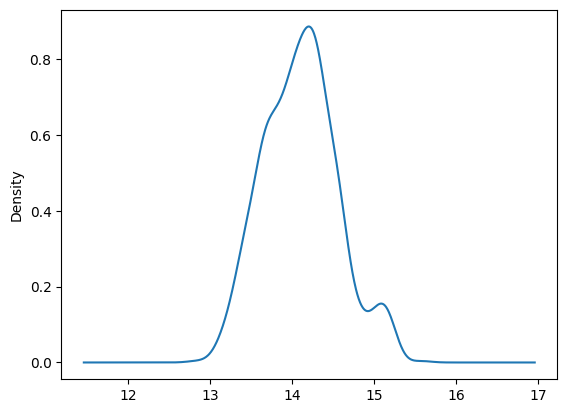

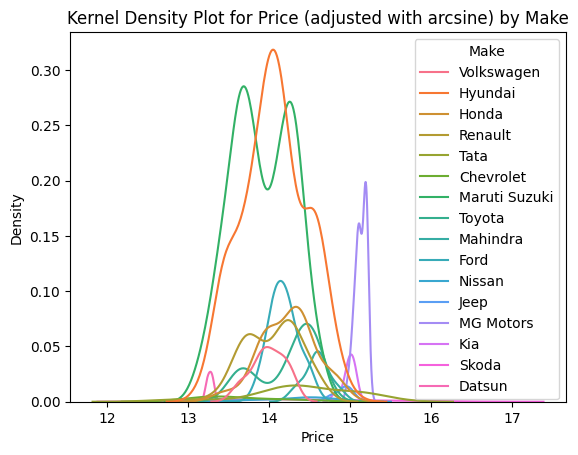

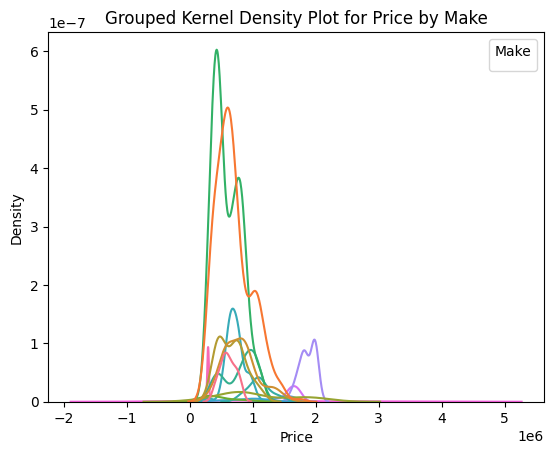

<Figure size 640x480 with 0 Axes>

In [32]:
#Q2
#Summarize the Price variable and create a kernel density plot. Use .groupby() and .describe() to summarize prices by brand (Make). Make a grouped kernel density plot by Make. Which car brands are the most expensive? What do prices look like in general?

print(df['Price'].describe())

df['Price_arc'] = np.arcsinh(df['Price'])
df['Price_arc'].plot.density() # creates a kernel density plot
plt.figure()

print(df.loc[:,['Make','Price']].groupby('Make').describe()) #calculates summary statistics for the 'Price' column within each group

sns.kdeplot(data = df, x = 'Price_arc',hue='Make') # Creates another kernal density plot; visualizes the distribution of 'Price_arc' for different categories of 'Make'.
plt.xlabel('Price')
plt.title('Kernel Density Plot for Price (adjusted with arcsine) by Make')
plt.figure()

sns.kdeplot(data = df, x = 'Price',hue='Make')
plt.xlabel('Price')
plt.title('Grouped Kernel Density Plot for Price by Make')
plt.legend(title='Make', loc='upper right')
plt.figure()

In [33]:
#Q3
#Split the data into an 80% training set and a 20% testing set.
from sklearn.model_selection import train_test_split

X = df.drop(['Price', 'Make_Year', 'Mileage_Run','Price_arc', 'No_of_Owners'], axis=1) #Inspired from Chat
X_train, X_test, y_train, y_test = train_test_split(X,df['Price_arc'],test_size=.2,random_state=100) # Taken from lecture notes

TSS = sum((y - (sum(y_test) / len(y_test))) ** 2 for y in y_test) # Calculates the total sum of squares
print(TSS)
Point_test = len(y_test) #calculates the number of points in data set
print(Point_test)

39.78849909547917
195


In [34]:
#Q4
#Let's focus on linear models. Make a model where you regress price on the numeric variables alone; what is the  R2  and RMSE on the test set?
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

#split data into numeric and categorical data
numeric = X_train.select_dtypes(include=['int64', 'float64']).columns # select_dtypes from Chat; method is used to select columns from a DataFrame
categorical = X_train.select_dtypes(include=['object', 'category']).columns

#Applying numeric data to test and training functions
numeric_X_train = X_train[numeric]
numeric_X_test = X_test[numeric]

#Completeing the regression
q41 = LinearRegression() # setting q41 as the LinearRegression variable type
q41.fit(numeric_X_train, y_train)
num_y_pred = q41.predict(numeric_X_test)
print('Numeric model - R2:', r2_score(y_test, num_y_pred), ' & RMSE:', mean_squared_error(y_test, num_y_pred, squared=False))


#Make a second model where, for the categorical variables, make a model comprised of one-hot encoded regressors/features alone, and regress price on those variables; what is the  R2  and RMSE on the test set?
from sklearn.preprocessing import OneHotEncoder
OneHotEncoder = OneHotEncoder(handle_unknown='ignore') #From Chat
OHE_X_train = OneHotEncoder.fit_transform(X_train[categorical]).toarray()
OHE_X_test = OneHotEncoder.transform(X_test[categorical]).toarray()

q42 = LinearRegression()
q42.fit(OHE_X_train, y_train)
cat_y_pred = q42.predict(OHE_X_test)
print('OneHotEncoder/categorical model - R2:', r2_score(y_test, cat_y_pred), ' & RMSE:', mean_squared_error(y_test, cat_y_pred, squared=False))


#Which model performs better on the test set?
print('The categorical model (model #2) is superior to the numeric model since the R2 value is greater, showing a closer fit of the model. That being said, neither model 1 nor 2 had a high R2 value.')
print('The RSME value for the numeric model was higher than the categorical model. This means that the numeric model can predict the data more accurately.')


#Make a third model that combines all the regressors from the previous two; what is the  R2  and RMSE on the test set? Does the joint model perform better or worse, and by home much?
from sklearn.preprocessing import PolynomialFeatures
PolynomialFeatures = PolynomialFeatures(degree=1) # From chat; fixes issues around coverting strings to floats: 'Maruti Suzuki'
X_train = PolynomialFeatures.fit_transform(numeric_X_train)
combined_X_train = np.concatenate((X_train, OHE_X_train),axis=1)
X_test = PolynomialFeatures.transform(numeric_X_test)
combined_X_test = np.concatenate((X_test, OHE_X_test),axis=1)

lr_combined = LinearRegression()
lr_combined.fit(combined_X_train, y_train)
combined_y_predictor = lr_combined.predict(combined_X_test)
print('Model 3 - R2:', r2_score(y_test, combined_y_predictor), '& RMSE:', mean_squared_error(y_test, combined_y_predictor, squared=False))

Numeric model - R2: 0.46146779155421047  & RMSE: 0.331487620441252
OneHotEncoder/categorical model - R2: 0.6603171791540954  & RMSE: 0.2632681153576807
The categorical model (model #2) is superior to the numeric model since the R2 value is greater, showing a closer fit of the model. That being said, neither model 1 nor 2 had a high R2 value.
The RSME value for the numeric model was higher than the categorical model. This means that the numeric model can predict the data more accurately.
Model 3 - R2: 0.8291394177895838 & RMSE: 0.18671637782300876


In [35]:
#Q5
#Use the PolynomialFeatures function from sklearn to expand the set of numerical variables you're using, along with the categorical variables. As you increase the degree of the expansion, how do the  R2  and RMSE change?

from sklearn.preprocessing import PolynomialFeatures
def expander(data, exp): #From the notes; function for the expander process
    expander = PolynomialFeatures(degree=exp, include_bias=False)
    Z_train = expander.fit_transform(data)
    names = expander.get_feature_names_out()
    expanded_df = pd.DataFrame(data=Z_train, columns=names)
    return expanded_df

def evaluate_model(X_train, X_test, y_train, y_test, degree): #From Chat; I created broken code Chat cleaned it up
    X_train_exp = expander(X_train, degree) # Expand the features; degree changes from 2 to 3 based on needs of question.
    X_test_exp = expander(X_test, degree)
    model = LinearRegression()  # Create a linear regression model
    model.fit(X_train_exp, y_train)  # Fit the model on the training data
    y_pred = model.predict(X_test_exp)  # Predict the values on the testing data
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    return r2, mse

#At what point does  R2  go negative on the test set? For your best model with expanded features, what is the  R2  and RMSE? How does it compare to your best model from part 3?

for degree in range(1, 5):
    R2, MSE = evaluate_model(X_train, X_test, y_train, y_test, degree)

    print("Degree of ", {degree},":")
    print("R2 Score:", R2)
    print("Mean Squared Error:", MSE)
    print(" ")

    if R2 < 0:
        print("R2 score became negative at degree ",{degree})
        print(" ")
        break

print("As the polynomial degree increases, R2 decreases and turns negative at degree 3, while RMSE surges significantly. The best model in this study is at degree 2, but the original model with all variables outperforms in terms of R2 and RMSE.")
print("Compared to model from part 4 (not 3) the model performed worse, with a lower R2. That being said, the RSME was lower than the resuts of q4. This  indicates that the q5 model's predictions are closer to the actual values ")

Degree of  {1} :
R2 Score: 0.4614677915542118
Mean Squared Error: 0.1098840425058033
 
Degree of  {2} :
R2 Score: 0.48067281999796296
Mean Squared Error: 0.10596537965009639
 
Degree of  {3} :
R2 Score: 0.33989354940625593
Mean Squared Error: 0.1346904867300982
 
Degree of  {4} :
R2 Score: -401.3724809672253
Mean Squared Error: 82.10152356415462
 
R2 score became negative at degree  {4}
 
As the polynomial degree increases, R2 decreases and turns negative at degree 3, while RMSE surges significantly. The best model in this study is at degree 2, but the original model with all variables outperforms in terms of R2 and RMSE.
Compared to model from part 4 (not 3) the model performed worse, with a lower R2. That being said, the RSME was lower than the resuts of q4. This  indicates that the q5 model's predictions are closer to the actual values 


The best performing model overall has been the 3rd model from Q4.


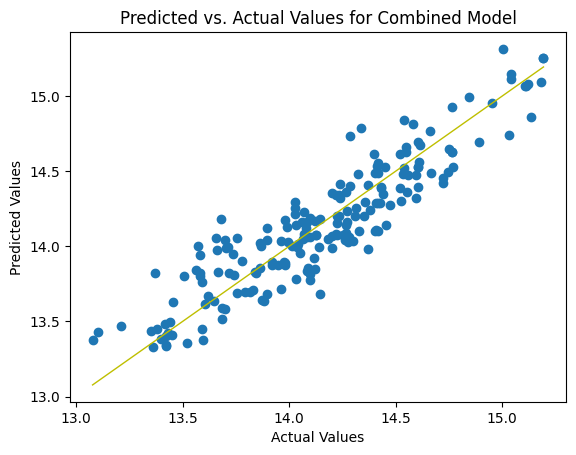

The predicted vlaues do appear align with the residuals


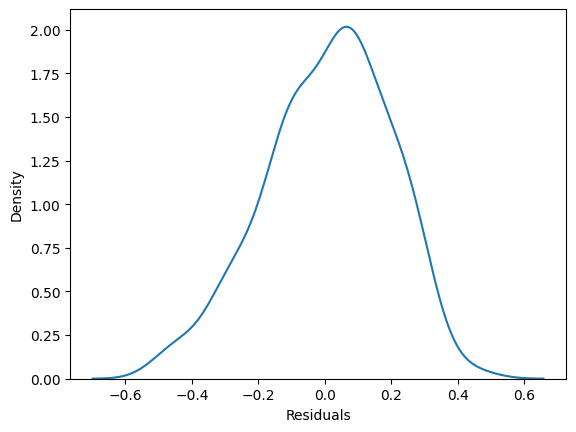

Mean of residuals: {0.008386065567139257}
Standard Deviation of residuals: {0.18652795943677772}


In [36]:
#Q6
#For your best model so far, determine the predicted values for the test data and plot them against the true values. Do the predicted values and true values roughly line up along the diagonal, or not?
print("The best performing model overall has been the 3rd model from Q4.")

plt.scatter(y_test, combined_y_predictor)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '-y', linewidth=1)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values for Combined Model')
plt.show()
print("The predicted vlaues do appear align with the residuals")

#Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero? Evaluate the strengths and weaknesses of your model.

residuals = y_test - combined_y_predictor #Calculating residuals; the differences between the observed (actual) values of the dependent variable
sns.kdeplot(residuals)
plt.xlabel('Residuals')
plt.show()

# Evaluate residuals
print('Mean of residuals:', {np.mean(residuals)})
print('Standard Deviation of residuals:', {np.std(residuals)})


Q6

The density plot indicates a roughly normal distribution around 0, signifying that my model performs well in predicting car prices. This instills confidence in the accuracy of price predictions based on the model's chosen characteristics. A concern is the long tail on the left side of the graph, suggesting occasional overpricing of cars due to negative residuals. This limitation diminishes my confidence in predictions, especially in scenarios like obtaining car insurance, where overestimating a car's value could lead to higher insurance costs. While the model's alignment with the diagonal line and the bell curve shape of residuals supports its overall accuracy, the tendency to overpredict on larger values remains a notable weakness.

Depth: 1, R2: 0.2899, RMSE: 0.3806
Depth: 2, R2: 0.3793, RMSE: 0.3559
Depth: 3, R2: 0.4244, RMSE: 0.3427
Depth: 4, R2: 0.4160, RMSE: 0.3452
Depth: 5, R2: 0.4393, RMSE: 0.3382
Depth: 6, R2: 0.4217, RMSE: 0.3435
Depth: 7, R2: 0.3476, RMSE: 0.3649
Depth: 8, R2: 0.2596, RMSE: 0.3887
Depth: 9, R2: 0.3235, RMSE: 0.3715

 Best Tree Depth: 5 
 Best R2: 0.43927471641162974 
 Best RMSE: 0.33824901643966515


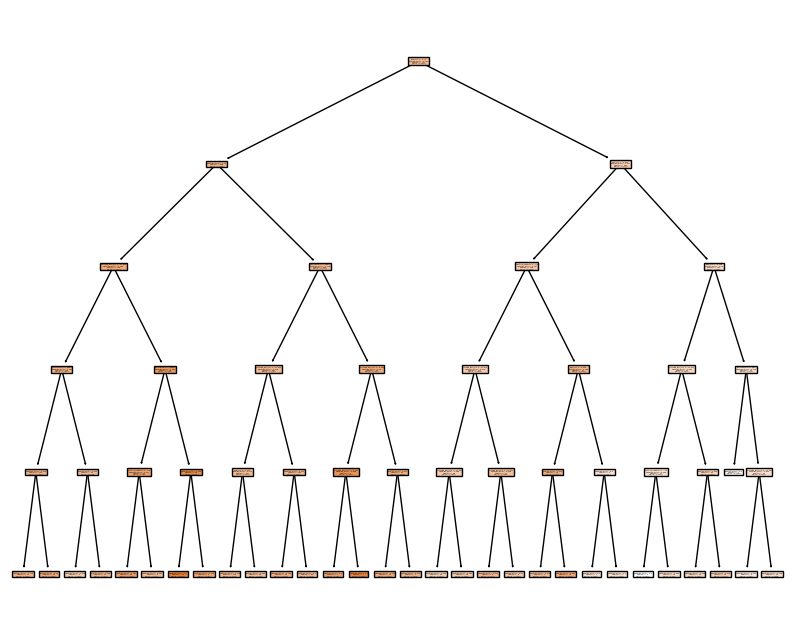

In [75]:
#Q7
#Now, let's use a regression tree. Construct an appropriate matrix of regressors/features, and fit a tree to the data. Vary the maximum depth of the decision tree using the max_depth option (i.e. tree.DecisionTreeRegressor(max_depth=D)), and compute the  R2  and RMSE on the test set of a variety of depths.
from sklearn.tree import DecisionTreeRegressor # Import the tree classifier
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier

best_depth = 0
best_r2 = float('-inf') # Developed using Chat to test out each tree iteration
best_rmse = float('inf') # Developed using Chat to test out each tree iteration

for depth in range(1, 10): #From the lecture
    tree = DecisionTreeRegressor(max_depth=depth)
    tree.fit(numeric_X_train, y_train)
    tree_y = tree.predict(numeric_X_test)

    # Developed using Chat to test out each tree iteration
    tree_r2 = r2_score(y_test, tree_y)
    tree_rmse = mean_squared_error(y_test, tree_y, squared=False)
    if tree_r2 > best_r2:
        best_r2 = tree_r2
        best_rmse = tree_rmse
        best_depth = depth
    print(f'Depth: {depth}, R2: {tree_r2:.4f}, RMSE: {tree_rmse:.4f}') #Developed from Chat

print("\n Best Tree Depth:", best_depth, "\n Best R2:", best_r2, "\n Best RMSE:", best_rmse)

cart = DecisionTreeRegressor(max_depth=best_depth) # Create a classifier object; 3 was determined to be too much based on branching dist.
cart = cart.fit(numeric_X_train, y_train) # Fit the classifier
plt.figure(figsize=(10, 8))
plot_tree(cart, filled=True, feature_names=numeric_X_train.columns)
plt.show()

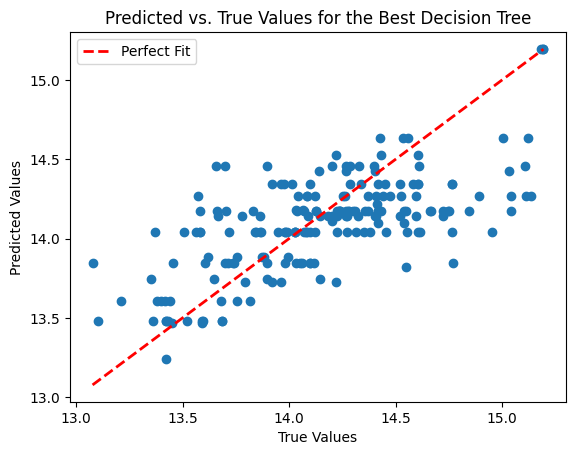

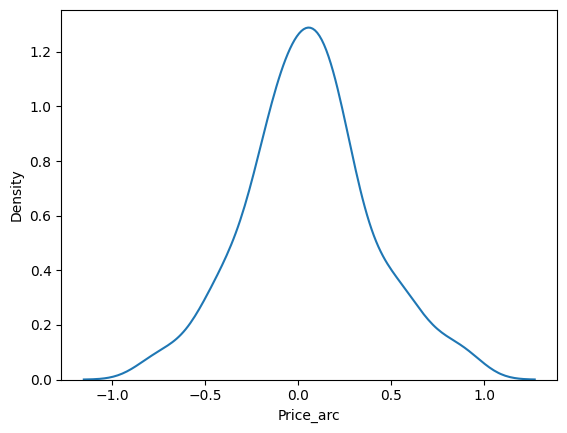

In [79]:
#Q8
#For your best tree, determine the predicted values for the test data, and plot them against the true values.

best_tree = cart
best_tree.fit(numeric_X_train, y_train)
best_tree_y_predict = best_tree.predict(numeric_X_test) # Make predictions using the best Decision Tree model // From Chat

plt.figure()
plt.scatter(y_test, best_tree_y_predict) # Plot the predicted vs true values for the best Decision Tree
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2, label='Perfect Fit') # Perfect fit line

# Labels and title
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. True Values for the Best Decision Tree')
plt.legend() # Legend
plt.show() # Show the plot

#Do the predicted values and true values line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero?
print('Yes, the predicted values and true values roughly line up along the diagonal')
residuals_best_tree = y_test - best_tree_y_predict
sns.kdeplot(residuals_best_tree) # Create a kernel density plot for the residuals of the best tree
plt.show()
print('Yes, the residuals roughly look bell shaped around 0')

Q9
Which model --- linear model or classification and regression tree --- has better performance on the test set?

The linear model, incorporating both categorical and numeric variables without any expansion, exhibits slightly superior performance on the test set. In particular, its R2 is 0.82913 compared to the R2 of 0.43927 of the tree model.

**Q2.** The is a question about regression using decision trees and linear models. The data include wages at data science-y jobs, including

  - `Rating`: Company worker happiness score
  - `Size`: Number of employees
  - `Sector`: Part of the economy
  - `avg_salary`: Average wage
  - `job_state`: Location of work

  1. Load the `wages_hw.csv` file. Split the sample into an ~80% training set and a ~20% test set. Do any necessary cleaning, including outliers and missings.
  2. Use a linear model to regress `avg_salary` on `Sector`. Which sectors have the highest predicted wages? What is the $R^2$ and `RMSE` on the test set?
  3. Make a scatterplot of `avg_salary` and `Rating`. Is there an obvious visual relationship between the two variables? Regress `avg_salary` on `Rating` as a numeric variable: Do higher ratings predict higher or lower wages? Convert `Rating` to a one-hot encoded variable, with a category for each rating. Run a regression of `avg_salary` on the categorical version. How do your results change? Explain. Which version has a higher $R^2$ and lower `RMSE`?
  4. Now interact `Sector` with the categorical version of `Rating`, so your regressors are a (Sector, Rating) pair; this is a programming puzzle you'll have to think about, but using the `.PolynomialFeatures()` function on the one-hot encoded categorical variables is one option, and another is pre-processing a new variable that interacts `Sector` and `Rating` and then one-hot encoding the result. Regress `avg_salary` on the (Sector, Rating) pairs. How does the $R^2$ and `RMSE` on the test set compare to part 2? Interpret the coefficients; which sector-rating pairs have the highest wages?
  5. Run a linear regression of `avg_salary` on all the variables. What is the $R^2$ on the test set? How does it compare to your simpler models in 2--4?
  6. Build a decision tree by regressing `avg_salary` on `Sector`, `Rating`, and the (Sector, Rating) pairs. What are the $R^2$ and `RMSE` of your models on the test set? How do your answers compare to parts 2, 3, and 4?
  7. Build a decision tree by regressing `avg_salary` on all the other variables. What is the $R^2$ and `RMSE` on the test set?
  8. Build a linear regression or decision tree using the available variables based on your own judgment. What degrees of freedom are you giving the model to predict variation in wages across company and location attributes? What is the $R^2$ and `RMSE` of your model? How does it compare to the previous ones in the question? Why does yours perform better or worse on the test set?

**Q3.** This a question purely on categorical prediction. The data for this happen to be gathered in 1987 in Indonesia, and concern contraceptive method choice. The questions and data-gathering assumptions reflect the culture and attitudes of that time and place, but provide a good example of a categorical prediction problem on an important topic (family planning and maternal health The variables in the data are:

    - Wife's age (numerical)
    - Wife's education (categorical) 1=low, 2, 3, 4=high
    - Husband's education (categorical) 1=low, 2, 3, 4=high
    - Number of children ever born (numerical)
    - Wife's religion (binary) 0=Non-Islam, 1=Islam
    - Wife's now working? (binary) 0=Yes, 1=No
    - Husband's occupation (categorical) 1, 2, 3, 4
    - Standard-of-living index (categorical) 1=low, 2, 3, 4=high
    - Media exposure (binary) 0=Good, 1=Not good
    - Contraceptive method used (class attribute) 1=No-use, 2=Long-term, 3=Short-termhort-term

  1. Load the `contraceptiveMethodChoice.csv` data. Tabulate the `method` variable (i.e. `.value_counts()`). 1 corresponds to `No Contraception`, 3 corresponds to `Short Term` (e.g. condoms, birth control pills), and 2 corresponds to `Long Term` (e.g. IUD, sterilization). Cross tabulate `method` and `numberChildren`. Do couples that use birth control tend to have more children than those who don't?
  2. Split the sample into ~80% training data and ~20% testing data.
  3. We are now going to make a mistake. Train a regression tree to predict the contraceptive method using the other variables in the data, not a classification tree. Look at the terminal nodes in the tree: What values do they take? Does that make sense? Explain clearly what has gone wrong here.
  4. Instead of regression, use a classification tree to predict contraceptive method using the other variables in the data. How does it look different from the previous tree? What variables does the algorithm use? In broad terms, which groups of people are most likely to use each method of contraception?
  5. Compute a confusion matrix for your classification tree on the test set (Hint: There are now three categories instead of two, so the cross tabulation will be a $3 \times 3$ matrix instead of $2 \times 2$.). Compute the Accuracy of your model overall, and the Accuracy for predicting each contraceptive method.
  7. Why can't you use a linear probability model to do this exercise? Explain clearly in words.

**Q4.** This is a question where we use regression and regression trees. The outcome is whether a defendant is held pre-trial in the Virginia justice system. We would like to understand how that outcome is predicted by characteristics of the defendant, particularly race. Let's be very careful/clear: We aren't saying anyone *should* be held without bond or asserting that people with different demographic variables *should* be more likely to be held, but instead trying to predict whether people with different characteristics *are empirically more likely* to be held without bond, given the available information. This is the first step we would take in investigating whether a system is fair, or how large the disparities are: Does it treat people with similar observable characteristics similarly, or not? We are going to look at a common question: Are Black defendants treated differently from white or Asian ones? (There are Native American defendants, but there are 11 in total, which is such a small number of observations that is difficult to clearly say anything about how this group is treated relative to the others.)

The variables in the data are:

  - `held_wo_bail`: Whether a defendant is held without bail before trial (Boolean logical)
  - `race`, `sex`: Categorical demographic variables
  - `is_poor`: Whether the defendant is classified as indigent
  - `prior_F`, `prior_M`: The number of prior felony and misdemeanor arrests
  - `case_type`: A categorical variable indicating a misdemeanor `M` or felony `F` or infraction `I` or special case `S`
  - `age`: Defendant's age
  - `bond`, `bond_NA`, `bond_type`: The amount of any bond, whether it is missing, and the type
  - `sentence`, `sentence_NA`, `sentence_type`: The length of any sentence, whether it is missing, and the type

1. Load the `pretrial_data.csv` data. Notice that there are `nan`s, but the data are relatively clean. Because there are `.nan`s among variables you won't use, you'll want to narrow down your analysis to the relevant variables before dropping or imputing missing values.
2. Create a dummy variable indicating that the defendant is Black.
3. Regress `held` on `Black`. What is the slope coefficient Interpret the coefficient on the Black dummy variable: How much more likely is a black person to be held without bail? What is the $R^2$ of the model?
4. Before doing this question, please think for a few minutes about how to make the process of running these regressions as efficient as possible, before jumping into writing code. Repeat part 2, for the following specifications, keeping track of the coefficient on the Black dummy variable each time:
      - `held` on `Black` and `sex`
      - `held` on `Black` and `sex` and `is_poor`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F` and `case_type`
What happens to the coefficient on the Black dummy variable as you include more regressors/features/controls in the regression? Explain your findings.
5. Suppose we don't want to see just `Black` and `sex`, but `Black` interacted with `sex`: Are Black men and Black women treated systemically differently from the rest of the population? Implement this in a regression, and explain your findings.
6. Imagine someone argued we should use these kinds of models to help a judge or magistrate make bail decisions (you could obviously go back and make this kind of model for the bond and sentence variables, then deploy it on new cases to predict what their bond and sentence values would be). What concerns would you have? Do you think society should be using data-driven and automated tools like that? Explain your concerns clearly.

**Q5.** This is a math question to review the derivation of the OLS estimator (but only if you are into that kind of thing!). We are going to do it slightly differently from what we did in class, though. We will use a linear predictor and minimize the Sum of Squared Errors, just as in class. But, we are going to de-mean $X$ first, creating another variable $z_i = x_i - \bar{x}$ where
$$
\bar{x} = \dfrac{1}{N} \sum_{i=1}^N x_i,
$$
so the model is $\hat{y}_i = a + b z_i$ and the `SSE` is
$$
\text{SSE}(a,b) = \sum_{i=1}^N (y_i - a - bz_i)^2.
$$

  1. Take partial derivatives of the `SSE` with respect to $a$ and $b$. You should get

\begin{eqnarray*}
\sum_{i=1}^N -2(y_i - a- bz_i) &=& 0 \\
\sum_{i=1}^N -2(y_i - a - bz_i)z_i &=& 0.
\end{eqnarray*}

  2. Solve for the solutions to the above equations. Big hint: $\bar{z} = 0$, since we subtracted the mean of $x$ from $x$ to get $z$. You should get

\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\sum_{i=1}^N(y_i - \bar{y})z_i}{\sum_{i=1}^N z_i^2}.
\end{eqnarray*}

  3. Substitute $z_i = x_i - \bar{x}$ back into the above equations. You should get
  
\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\sum_{i=1}^N(y_i - \bar{y})(x_i-\bar{x})}{\sum_{i=1}^N (x_i-\bar{x})^2},
\end{eqnarray*}

which can be written in terms of sample covariance and sample variance as:

\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\text{cov}(x,y)}{\text{var}(x)}.
\end{eqnarray*}

This is typically the preferred way of expressing the OLS coefficients.

4. When will $b^*$ be large or small, depending on the relationship between $x$ and $y$ and the amount of "noise"/variance in $x$? What does $a^*$ represent?
5. Suppose you have measurement error in $x$ which artificially inflates its variance (e.g. bad data cleaning). What happens to the $b^*$ coefficient? How will affect your ability to predict? (This phenomenon is called **attenuation**.)
6. Let's return to the question of *outliers*. With your formula for the OLS coefficients $(a^*,b^*)$, explain what happens if you significantly increase a single value of the outcome/target/response variable $y_i$ or one of the predictor/explanatory/covariate variables $x_i$. If values for some extreme observations are exerting significant influence over the regression coefficients, will the model perform well on for more average observations?

Link to work for parts 1, 2, & 3: https://drive.google.com/file/d/1obJMU0hlSA3C0jwQm-LpqPQ6ReLhTPqB/view?usp=sharing

Q4: b∗ will be larger when there is a close relationship between x & y. b∗ will be smaller when there is a weak relationship between x & y. a ∗ b ∗ represents the ratio of the sample covariance between x and y to the sample variance of x, multiplied by the mean of y and b* representing the slope of the linear regression. a∗ represents the intercept of the regression.

Q5: When the variance of x is increased, the coefficient b∗ tends to decrease due to the enlargement of the denominator, bringing b∗ closer to 0. This effect on b∗ may result in an underestimation of the linear relationship between x and y, making the model less dependable.

Q6: Possibly. Extreme values can skew the sample mean and variance, affecting both the intercept and slope of the model. In this case the model would be tailored to fit extreme observations, potentially leading to poorer performance on more average observations.

Furthermore, if a single extreme value significantly impacts the outcome or predictor variables in your Ordinary Least Squares (OLS) regression model, the coefficients  a∗ and b∗ can be heavily influenced.